In [1]:
import numpy as np

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.formats import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.transformers import FreezeCoreTransformer

from qiskit_algorithms.optimizers import SLSQP
from qiskit_algorithms.minimum_eigensolvers import AdaptVQE, VQE

from qiskit.primitives import Estimator

In [36]:
# Use PySCF, a classical computational chemistry software
# package, to compute the one-body and two-body integrals in
# molecular-orbital basis, necessary to form the Fermionic operator
info = MoleculeInfo(
    ["Na", "H"],
    [
        (0.0000, 0.0000, 0.0000),     # Sodium at origin
        (0.0000, 0.0000, 1.887),      # Hydrogen 1.887 Å along z-axis (approximate bond length)
    ]
)


driver = PySCFDriver.from_molecule(info, basis="sto3g")
molecule = driver.run()

transformer = FreezeCoreTransformer()
molecule = transformer.transform(molecule)
hamiltonian = molecule.hamiltonian.second_q_op()
mapper = ParityMapper(num_particles=molecule.num_particles)
tapered_mapper = molecule.get_tapered_mapper(mapper)
qubit_op = tapered_mapper.map(hamiltonian)

In [37]:
# setup the initial state for the variational form
init_state = HartreeFock(
            molecule.num_spatial_orbitals,
            molecule.num_particles,
            tapered_mapper,
        )

estimator = Estimator()

optimizer = SLSQP(maxiter=10000, ftol=1e-9)

/tmp/ipykernel_248/1276863301.py:8: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


In [38]:
import time
vqe_ansatz = UCCSD(
    molecule.num_spatial_orbitals,
    molecule.num_particles,
    tapered_mapper,
    initial_state=init_state
)
i=0
UCC_diff_times = []
while i<1:
    UCCstime = time.time()
    vqe = VQE(estimator, vqe_ansatz, optimizer)
    vqe.initial_point = [0] * vqe_ansatz.num_parameters
    algo = GroundStateEigensolver(tapered_mapper, vqe)
    result_vqe = algo.solve(molecule)
    print(result_vqe)
    energy_vqe = result_vqe.eigenvalues[0]
    UCCetime = time.time()
    UCC_diff_times.append(UCCetime - UCCstime)
    i+=1


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -163.400080169356
  - computed part:      -0.814454852864
  - FreezeCoreTransformer extracted energy part: -162.585625316492
~ Nuclear repulsion energy (Hartree): 3.084763815644
> Total ground state energy (Hartree): -160.315316353712
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  3.5659132]
 
  0: 
  * Electronic dipole moment (a.u.): [None  None  5.95848909582]
    - computed part:      [None  None  5.977055122539]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  -0.018566026719]
  > Dipole moment (a.u.): [None  None  -2.39257589582]  Total: None
                 (debye): [None  None  -6.081320765714]  Total: None
 


In [ ]:
adapt_vqe_ansatz = UCCSD(
    molecule.num_spatial_orbitals,
    molecule.num_particles,
    tapered_mapper,
    initial_state=init_state
)
import time
i=0
ADAPT_time_diffs = []
print(molecule.nuclear_repulsion_energy)
while i<1:
    adaptstime = time.time()
    adapt_vqe = AdaptVQE(VQE(estimator, adapt_vqe_ansatz, optimizer))
    result_adapt_vqe = adapt_vqe.compute_minimum_eigenvalue(qubit_op)
    energy_adapt_vqe = result_adapt_vqe.eigenvalue
    adaptetime = time.time()
    ADAPT_time_diffs.append(adaptetime - adaptstime)
    i+=1

3.0847638156438792


In [35]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Ansatz","Energy (Hartree)","Gates"]

vqe_cirq = result_vqe.raw_result.optimal_circuit
table.add_row(['UCCSD', str(energy_vqe), vqe_cirq.count_ops()])

adapt_vqe_cirq = result_adapt_vqe.optimal_circuit
table.add_row(['ADAPT-VQE', str(result_adapt_vqe.eigenvalue), adapt_vqe_cirq.count_ops()])

print(table)

print("Average Execution time for 5 iterations of UCCSD = {:.4f} seconds".format(sum(UCC_diff_times)/len(UCC_diff_times)))
print("Average Execution time for 5 iterations of ADAPTVQE = {:.4f} seconds".format(sum(ADAPT_time_diffs)/len(ADAPT_time_diffs)))

nuclear_repulsion = molecule.nuclear_repulsion_energy
print(nuclear_repulsion + result_adapt_vqe.eigenvalue)
print(result_adapt_vqe.num_iterations)
print("Number of operators selected in ansatz:", len(adapt_vqe._excitation_list))
print(len(ADAPT_time_diffs))
print("VQE operators ", len(vqe_cirq._excitation_list))

+-----------+---------------------+----------------------------------+
|   Ansatz  |   Energy (Hartree)  |              Gates               |
+-----------+---------------------+----------------------------------+
|   UCCSD   | -23.857641802497223 | OrderedDict([('EvolvedOps', 1)]) |
| ADAPT-VQE |  -23.85763255198414 | OrderedDict([('EvolvedOps', 1)]) |
+-----------+---------------------+----------------------------------+
Average Execution time for 5 iterations of UCCSD = 82.0517 seconds
Average Execution time for 5 iterations of ADAPTVQE = 722.7194 seconds
-14.21412576423894
27
Number of operators selected in ansatz: 26
1
VQE operators  30


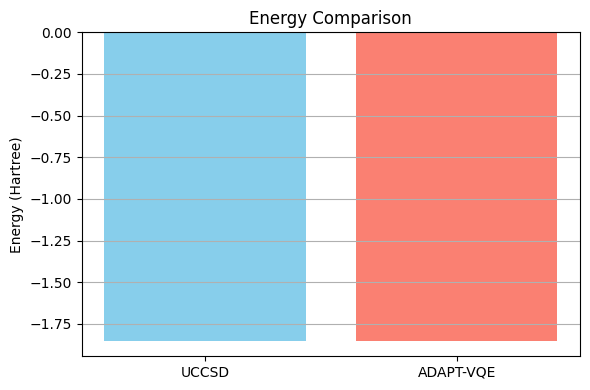

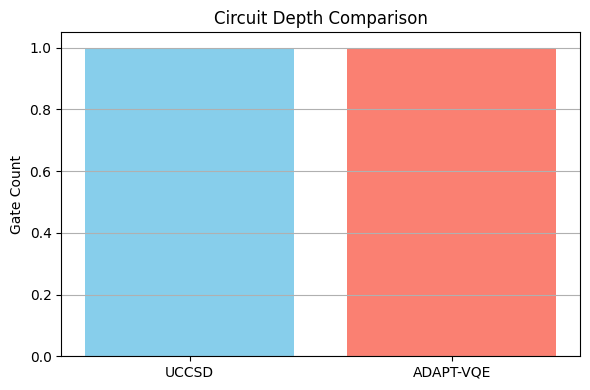

In [7]:
import matplotlib.pyplot as plt

# Energies (already computed)
energies = [energy_vqe, result_adapt_vqe.eigenvalue]  # ensure they're floats, not complex
labels = ['UCCSD', 'ADAPT-VQE']

# Gates (already extracted)
gate_counts = [vqe_cirq.count_ops().get("EvolvedOps", 0), adapt_vqe_cirq.count_ops().get("EvolvedOps", 0)]

# --- Plot Energy Comparison ---
plt.figure(figsize=(6, 4))
plt.bar(labels, energies, color=['skyblue', 'salmon'])
plt.ylabel("Energy (Hartree)")
plt.title("Energy Comparison")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# --- Plot Gate Count Comparison ---
plt.figure(figsize=(6, 4))
plt.bar(labels, gate_counts, color=['skyblue', 'salmon'])
plt.ylabel("Gate Count")
plt.title("Circuit Depth Comparison")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
